在此之前，已经从10x Genome上下载得到了原始数据。

Quality Control

d:\anaconda3\envs\cmml3_cpu\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\anaconda3\envs\cmml3_cpu\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3012 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
细胞数: 3012, 基因数: 36601


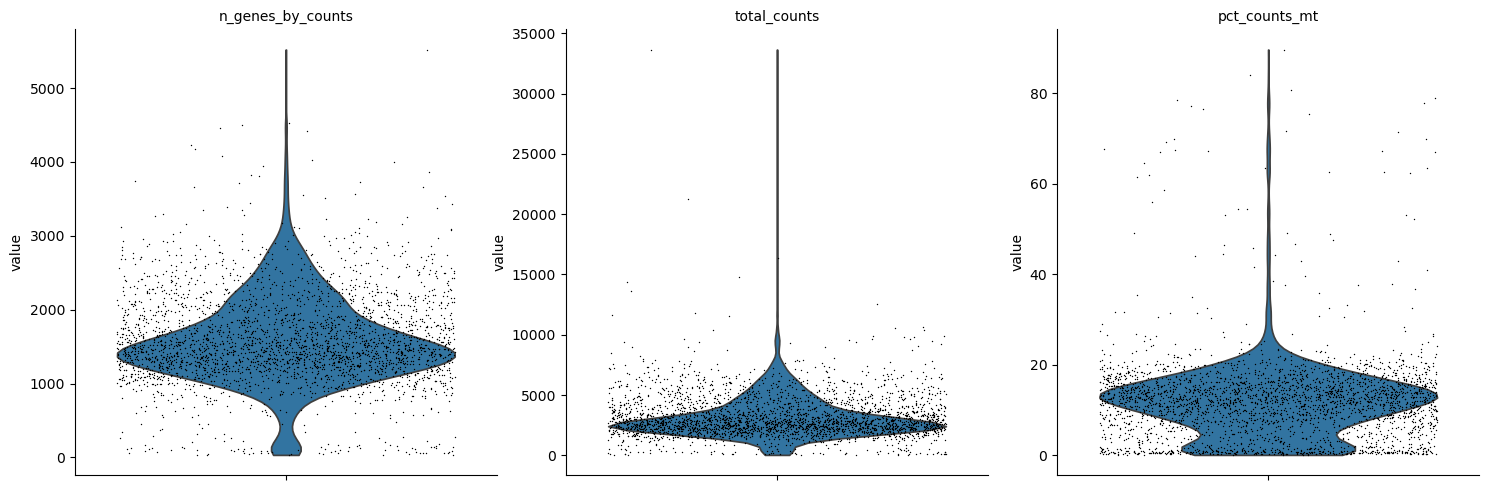

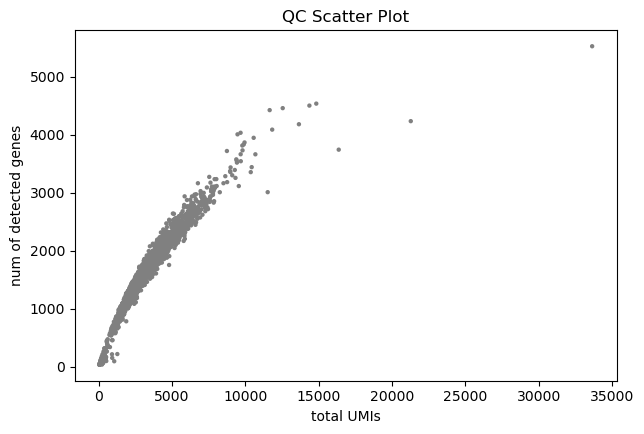

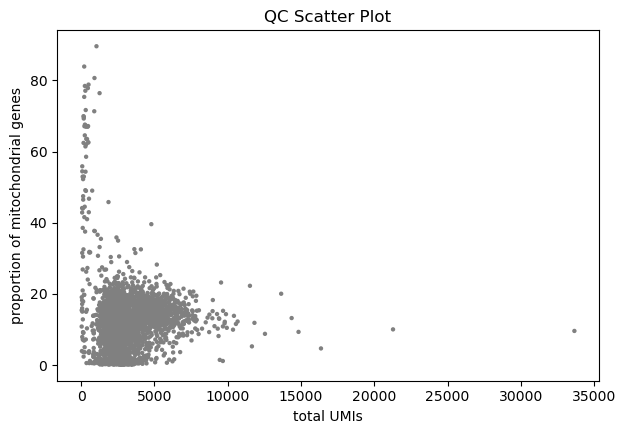

QC后保留细胞数量：1144


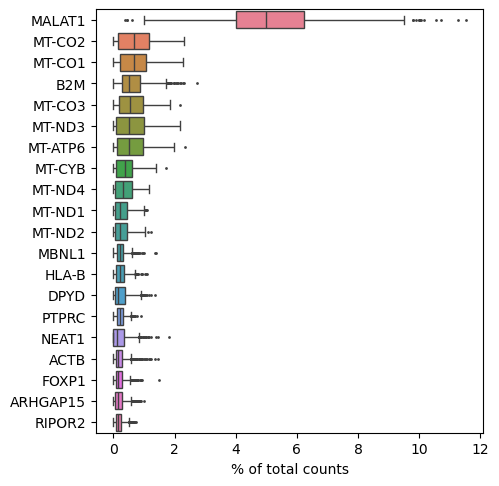

In [4]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy import io
import os
outdir = r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Results"
os.makedirs(outdir, exist_ok=True)

# 载入数据
adata_RNA = sc.read_10x_h5(
    r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Downloaded_Raw_Data\pbmc_unsorted_3k_filtered_feature_bc_matrix.h5"
)
adata_RNA.var_names_make_unique() # 确保基因名唯一

# 查看基本结构、基因数[num of detected genes]、细胞数
print(adata_RNA)
print(f"细胞数: {adata_RNA.n_obs}, 基因数: {adata_RNA.n_vars}")

# 标记线粒体基因（人类线粒体基因通常以"MT-"开头）
adata_RNA.var['mt'] = adata_RNA.var_names.str.startswith('MT-')

# 计算常规 QC 指标
sc.pp.calculate_qc_metrics(
    adata_RNA,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

# QC指标可视化
sc.pl.violin(
    adata_RNA,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

sc.pl.scatter(
    adata_RNA,
    x='total_counts',
    y='n_genes_by_counts',
    show=False
)
plt.xlabel("total UMIs")
plt.ylabel("num of detected genes")
plt.title("QC Scatter Plot")
plt.show()

sc.pl.scatter(
    adata_RNA,
    x='total_counts',
    y='pct_counts_mt',
    show=False
)
plt.xlabel("total UMIs")
plt.ylabel("proportion of mitochondrial genes")
plt.title("QC Scatter Plot")
plt.show()

# 过滤低质量细胞并查看筛选结果  阈值需要动态调整
sc.pp.filter_cells(adata_RNA, min_counts=500)
sc.pp.filter_cells(adata_RNA, min_genes=200)
adata_RNA = adata_RNA[adata_RNA.obs['pct_counts_mt'] < 10, :].copy()

print(f"QC后保留细胞数量：{adata_RNA.n_obs}")

# 展示全体细胞中平均表达量最高的前20个基因，可帮助判断是否有污染或技术偏差
sc.pl.highest_expr_genes(adata_RNA, n_top=20)

Log Normalization

In [5]:
# 归一化每个细胞的表达总量
sc.pp.normalize_total(adata_RNA, target_sum=1e4)

# 对归一化的结果进行对数变换
sc.pp.log1p(adata_RNA)

注意到top20中有许多的线粒体基因，并且这已经是在过滤掉线粒体比例>10%的细胞后的结果。
也许这个细胞亚群本身就有较高的线粒体基因表达。

Screening highly variable genes

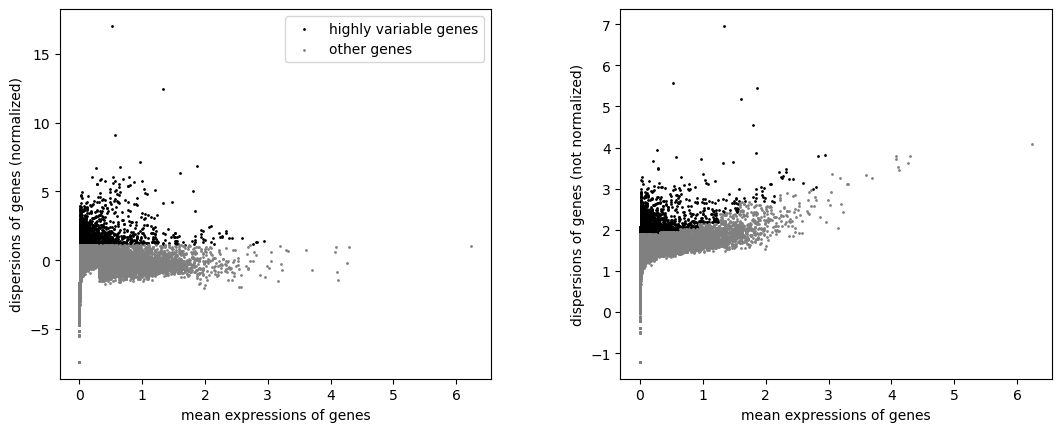

In [6]:
# 筛选出变异度最高的2000个基因
sc.pp.highly_variable_genes(
    adata_RNA,
    flavor='seurat',
    n_top_genes=2000
)

# 可视化高变基因的分布
sc.pl.highly_variable_genes(adata_RNA)

# 只保留高变基因用于后续分析
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable']].copy()

导出结果文件，用于准备scAI的输入文件

In [7]:
# 保存完整的 AnnData (包含 X、obs、var、obsm 等所有信息)
adata_RNA.write(
    r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Results\RNA_preprocessed.h5ad"
)

# 保存counts矩阵(genes × cells)，gene，barcode标签
rna_counts = adata_RNA.X.copy().T
io.mmwrite(
    r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Results\scAI_rna_counts.mtx",
    sp.csr_matrix(rna_counts)
)
pd.Series(adata_RNA.var_names, name='gene').to_csv(
    r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Results\scAI_rna_genes.tsv",
    sep="\t",
    index=False
)
pd.Series(adata_RNA.obs_names, name='cell').to_csv(
    r"D:\HuaweiMoveData\Users\hya\Desktop\CMML\ICA2\Results\scAI_rna_barcodes.tsv",
    sep="\t",
    index=False
)

PCA

In [ ]:
# PCA 降维
sc.tl.pca(adata_RNA, svd_solver='arpack')  # 可选 'arpack', 'randomized' 等

# 可视化前几个主成分的解释方差（即每个PC占总变异的比例）
sc.pl.pca_variance_ratio(adata_RNA, log=True, n_pcs=50) # log10比例图
sc.pl.pca_variance_ratio(adata_RNA, log=False, n_pcs=30) # 原始比例图

前5个主成分（PC1–PC5）显著高于其后，是信息量最集中的部分。
为了避免信息冗余，可以选择前20个主成分。